# Preprocesamiento de corpus para Análisis de sentimientos

### Importando librerías

In [3]:
#%pip install -U langdetect
#%pip install spacy

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

import spacy

import unicodedata
import re

from langdetect import detect

### Cargando datos

In [5]:
df = pd.read_csv('../data/raw/train.csv', index_col=[0], parse_dates=['Date'])
df

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0
...,...,...,...,...,...,...,...,...
4412,"""Beautiful architecture""","""This university is famous because of its beau...",Universidad de Guanajuato,Male,24,México,21/04/2014,1
4413,"""Imponente la universidad, TODO guanajuato es ...","""Lo que no me gusto fue la comida, pero es muy...",Universidad de Guanajuato,Female,44,México,05/07/2015,1
4414,Lugar magico,Esta excelente para pasar a sentarse unos minu...,Jardín de la Unión,Male,-1,México,2018,1
4415,"""¡Su fachada es hermosa!""","""No tuvimos la fortuna de entrar a verlo, ya q...",Teatro Juárez,Female,47,México,22/10/2012,1


__________________________________________________________________________________________________________________________________________

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4417 entries, 0 to 4416
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    4416 non-null   object
 1   Opinion  4415 non-null   object
 2   Place    4417 non-null   object
 3   Gender   4417 non-null   object
 4   Age      4417 non-null   int64 
 5   Country  4417 non-null   object
 6   Date     4417 non-null   object
 7   Label    4417 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 310.6+ KB


#### Valores perdidos

Sólo hay 3 casos

In [7]:
# Valores nulos
df.isna().sum()

Title      1
Opinion    2
Place      0
Gender     0
Age        0
Country    0
Date       0
Label      0
dtype: int64

In [8]:
df[df['Title'].isna()]

,Title,Opinion,Place,Gender,Age,Country,Date,Label
2209,NaN,"De los lugares más bonitos de Guanajuato, a un...",Jardín de la Unión,N/I,-1,México,2019,1


In [9]:
df[df['Opinion'].isna()]

,Title,Opinion,Place,Gender,Age,Country,Date,Label
1142,Lugar lleno de historia,NaN,Alhóndiga,Male,-1,México,2019,1
3712,punto cental,NaN,Basilica Colegiata,Male,-1,Argentina,2018,1


#### Valores atípicos

In [10]:
df['Place'].unique()

array(['Museo de las Momias', 'Mercado Hidalgo', 'Callejón del Beso',
       'Basilica Colegiata', 'Monumento Pípila', 'Alhóndiga',
       'Teatro Juárez', 'Universidad de Guanajuato',
       'Casa de Diego Rivera', 'Jardín de la Unión'], dtype=object)

#### Análisis de genero

In [11]:
df['Gender'].value_counts()

Gender
Male      2298
Female    2059
N/I         60
Name: count, dtype: int64

#### Análisis Edad

In [12]:
df['Age'].unique()

array([48, 52, 42, 24, 19, -1, 33, 20, 44, 21, 16, 64, 25, 35, 29, 38, 53,
       55, 30, 36, 45, 32, 60, 41, 46, 51, 40, 56, 54, 28, 39, 49, 37, 43,
       50, 34, 17, 31, 68, 66, 47, 18, 23, 22, 57, 63, 27, 26, 61, 58, 67,
       59, 70, 65, 62, 69, 15, 71, 75, 76, 72, 77], dtype=int64)

#### Análisis País

In [13]:
df['Country'].unique()

array(['México', 'N/I', 'Perú', 'Paraguay', 'Ecuador', 'Panamá',
       'Argentina', 'Colombia', 'España', 'Costa Rica', 'Venezuela',
       'Estados Unidos', 'Alemania', 'Chile', 'Guatemala', 'Nicaragua',
       'Brasil', 'Bolivia', 'Uruguay', 'Francia', 'República Dominicana',
       'Canadá', 'El Salvador', 'Australia', 'Cuba', 'Italia', 'Rusia',
       'Israel', 'Andorra', 'Honduras', 'Indonesia', 'Gibraltar',
       'Bélgica', 'Inglaterra', 'China', 'Nueva Zelanda', 'Mozambique',
       'Emiratos Árabes Unidos', 'Eslovaquia', 'Suiza', 'Irlanda',
       'Belice', 'Islandia', 'Finlandia'], dtype=object)

#### Análisis Fechas

In [14]:
print(df['Date'].min())
print(df['Date'].max())

01/01/2014
31/12/2017


#### Balanceo de clases

Las clases están desbalanceadas, ya que más del 80% son opiniones positivas y el resto negativas.

Label
1    3643
0     774
Name: count, dtype: int64


<Axes: xlabel='Label'>

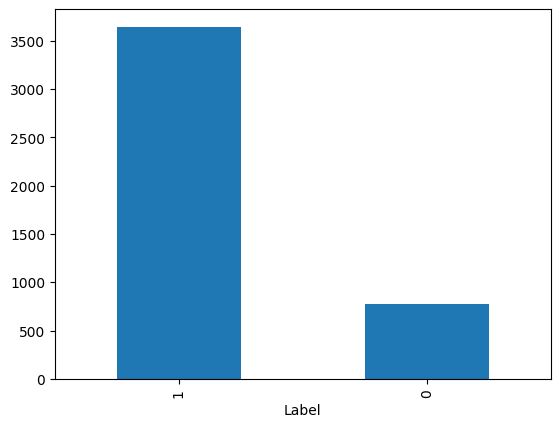

In [17]:
print(df['Label'].value_counts())
df['Label'].value_counts().plot(kind='bar')


__________________________________________________________________________________________________________________________________________

## PREPROCESAMIENTO

#### Funciónes

In [21]:
# Función para detectar el idioma del texto
def detectar_idioma(texto):
    try:
        return detect(texto)
    except:
        return 'unknown'

#--------------------------------------------------------------------------------------------------------------------------------------

# Función eliminación de acentos
def eliminar_acentos(texto):
    # Normalizamos el texto a la forma 'NFD' que separa los caracteres Unicode y sus diacríticos
    texto_normalizado = unicodedata.normalize('NFD', texto)
    # Filtramos todos los caracteres que no sean diacríticos (es decir, eliminamos los acentos)
    texto_sin_acentos = ''.join(c for c in texto_normalizado if unicodedata.category(c) != 'Mn')
    return texto_sin_acentos

#--------------------------------------------------------------------------------------------------------------------------------------

# Función para dejar solo letras y espacios, quitar caracteres extraños
def eliminar_caracteres_especiales(texto):
    #Utilizamos re.sub() para dejar solo las letras y los espacios
    texto_solo_caracter = re.sub(r"[^a-zA-Z\s]", "", texto)

    return texto_solo_caracter

#--------------------------------------------------------------------------------------------------------------------------------------

# Función para el preprocesamiento de los datos
def preprocesamiento(df, limpieza_extra = False):
    
    # Se sustituyen los valores nulos por un string vacío
    df['Title'] = df['Title'].fillna('')
    df['Opinion'] = df['Opinion'].fillna('')

    # Eliminar duplicados
    df_clean = df.drop_duplicates()
    len(df_clean)

    # Elminar triple comillas en textos
    df_clean['Title'] = df_clean['Title'].str.strip('"')
    df_clean['Opinion'] = df_clean['Opinion'].str.strip('"')

    # Convertir a minúsculas
    df_clean['Title'] = df_clean['Title'].str.lower()
    df_clean['Opinion'] = df_clean['Opinion'].str.lower()

    # Crear una columna con el idioma detectado en la Opinión
    df_clean['Lang'] = df_clean['Opinion'].apply(detectar_idioma)

    #Se seleccionan sólo opiniones en español
    df_final = df_clean[df_clean['Lang'] == 'es']

    if limpieza_extra:
        # Eliminar acentos
        df_final['Title'] = df_final['Title'].apply(eliminar_acentos)
        df_final['Opinion'] = df_final['Opinion'].apply(eliminar_acentos)

        # Eliminar caracteres especiales
        df_final['Title'] = df_final['Title'].apply(eliminar_caracteres_especiales)
        df_final['Opinion'] = df_final['Opinion'].apply(eliminar_caracteres_especiales)

    return df_final

#--------------------------------------------------------------------------------------------------------------------------------------

# Función para generar los archivos preprocesados
def genera_archivos(df):
    # Separar conjunto de entrenamiento y validación
    train, val = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
    
    df_train = pd.DataFrame(train)
    df_val = pd.DataFrame(val)

    # Guardar en CSV
    df_train.to_csv("../data/processed/train.csv")
    df_val.to_csv("../data/processed/val.csv")

    print('Proceso finalizado')

In [19]:
df_limpio = preprocesamiento(df, True)
genera_archivos(df_limpio)

C:\Users\Janneth\AppData\Local\Temp\ipykernel_29620\1585132074.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Title'] = df_clean['Title'].str.strip('"')
C:\Users\Janneth\AppData\Local\Temp\ipykernel_29620\1585132074.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Opinion'] = df_clean['Opinion'].str.strip('"')
C:\Users\Janneth\AppData\Local\Temp\ipykernel_29620\1585132074.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Proceso finalizado


C:\Users\Janneth\AppData\Local\Temp\ipykernel_29620\1585132074.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Opinion'] = df_final['Opinion'].apply(eliminar_caracteres_especiales)
